# Objective

In this notebook we will do a rough first attempt at building the cloud classifier. Specifically, we'll build a simple NN that's just a few hidden layers, not even a CNN. This will be the first in a series of notebooks where we build out more and more sophisticated models.

In [1]:
import tensorflow as tf
from tensorflow import keras
import joblib
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import datasets

2024-07-02 19:13:17.068278: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/adu/miniconda3/envs/clouds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_SEED = 0

## Data prep

In [3]:
data = datasets.load_dataset("aduuuuuu/CCSN", split="train")
# The classes info below will be used later for decoding and determining the output size
classes = data.features["label"].names
num_classes = len(classes)

data = data.to_tf_dataset()
data = data.map(lambda x: (x["image"], x["label"]))

def preprocess_data(image, label):
    # Normalize pixel values
    image = image/255
    image = tf.cast(image,  tf.float32)

    # Reshape
    if image.shape != (400, 400, 3):
        image = tf.image.resize(image, [400, 400])

    # Convert to greyscale
    image = tf.tensordot(image, tf.constant([0.299, 0.587, 0.114]), axes=[[2], [0]])
    # grey_image = tf.expand_dims(grey_image, -1)

    out = (image, label)
    return out

To use a simple NN, we're going to have to simplify our data. To do this, we're going to convert the images from RGB to greyscale. The `preprocess_data` function we just defined does this for us.

Let's look at a few images to see the preprocessing in action.

2024-07-02 19:13:48.133107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


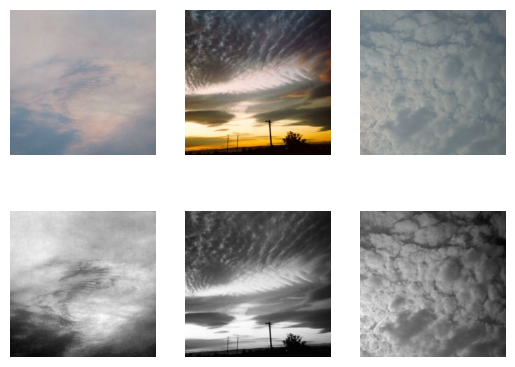

In [4]:
fig, axes = plt.subplots(2,3)
i = 0
for sample in data.shuffle(buffer_size=128).take(3):
    img_color = sample[0]
    img_grey = preprocess_data(sample[0], sample[1])[0]
    ax_color = axes[0, i]
    ax_grey = axes[1, i]
    ax_color.imshow(img_color)
    ax_grey.imshow(img_grey, cmap="grey")
    ax_color.axis("off")
    ax_grey.axis("off")
    i += 1

Before we start training, we need to shuffle and split the data:

In [5]:
def train_test_split(tfds, test_size=0.2, shuffle=True, random_seed=0):
    N = tf.data.experimental.cardinality(tfds).numpy()
    if shuffle:
        tfds = tfds.shuffle(buffer_size=N, seed=random_seed)

    N_test = int(N*test_size)
    tfds_test = tfds.take(N_test)
    tfds_train = tfds.skip(N_test)

    return tfds_train, tfds_test

data_train, data_test = train_test_split(data.map(preprocess_data), random_seed=RANDOM_SEED)

Later on we'll want to analyze the predictions and we'll want to know what the labels represent, so let's fit a label encoder:

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(classes)

LabelEncoder()

## Training

### Baby model

In [7]:
model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(400,400)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(num_classes)
])

model1.summary()

/Users/adu/miniconda3/envs/clouds/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    10,240,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,240,779 (39.07 MB)

 Trainable params: 10,240,779 (39.07 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model1.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
batch_size=64

model1.fit(data_train.batch(batch_size), epochs=5)

Epoch 1/5


2024-07-02 19:14:32.821919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 1874 of 2543
2024-07-02 19:14:36.853886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.0962 - loss: 31.4680
Epoch 2/5


2024-07-02 19:14:51.038797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2190 of 2543


 1/32 ━━━━━━━━━━━━━━━━━━━━ 6:14 12s/step - accuracy: 0.1406 - loss: 2.3965

2024-07-02 19:14:52.949762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.0993 - loss: 2.7063
Epoch 3/5


2024-07-02 19:15:06.653199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2217 of 2543


 1/32 ━━━━━━━━━━━━━━━━━━━━ 6:06 12s/step - accuracy: 0.0938 - loss: 2.3988

2024-07-02 19:15:08.326275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.1116 - loss: 2.3960
Epoch 4/5


2024-07-02 19:15:21.988707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2162 of 2543


 1/32 ━━━━━━━━━━━━━━━━━━━━ 6:15 12s/step - accuracy: 0.1094 - loss: 2.3955

2024-07-02 19:15:23.953300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.1037 - loss: 2.3942
Epoch 5/5


2024-07-02 19:15:37.644328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2206 of 2543


 1/32 ━━━━━━━━━━━━━━━━━━━━ 6:12 12s/step - accuracy: 0.1250 - loss: 2.3939

2024-07-02 19:15:39.506194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.1119 - loss: 2.3927


Let's evaluate this

In [9]:
probability_model1 = keras.models.Sequential([
    model1,
    keras.layers.Softmax()
])

def prediction_summary(model, image, label_name):
    plt.imshow(image, cmap="grey")
    plt.axis("off")
    plt.show()

    image = tf.expand_dims(image, axis=0)
    probabilities = model.predict(image)
    predicted = np.argmax(probabilities)
    predicted_label_name = le.inverse_transform(predicted.reshape(1,))
    predicted_proba = np.max(probabilities) * 100

    print(f"Predicted {predicted_label_name} with probabilitiy {predicted_proba:.1f}%")
    print(f"The true label is {label_name}")

    if predicted_label_name == label_name:
        return 1
    else:
        return 0

2024-07-02 19:16:03.428718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2063 of 2543
2024-07-02 19:16:05.955584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


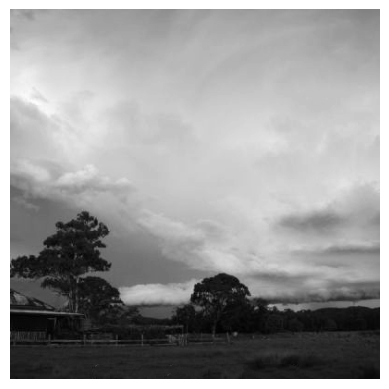

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted ['Sc'] with probabilitiy 9.5%
The true label is ['Cb']


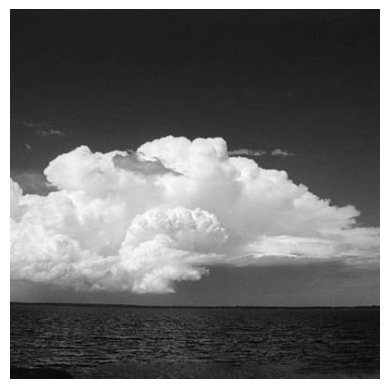

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted ['Sc'] with probabilitiy 9.5%
The true label is ['Cb']


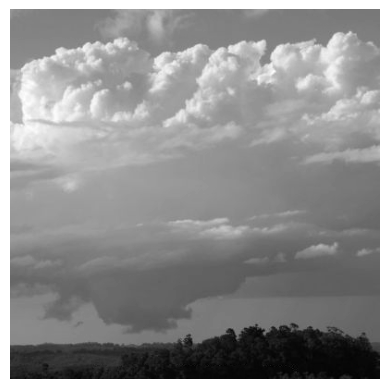

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted ['Sc'] with probabilitiy 9.5%
The true label is ['Cu']


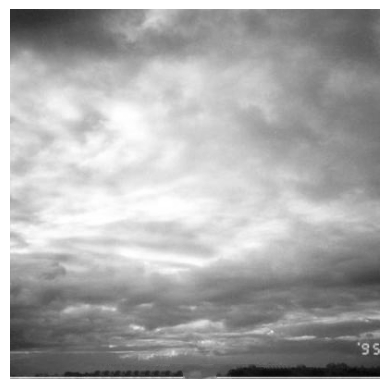

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted ['Sc'] with probabilitiy 9.5%
The true label is ['Sc']


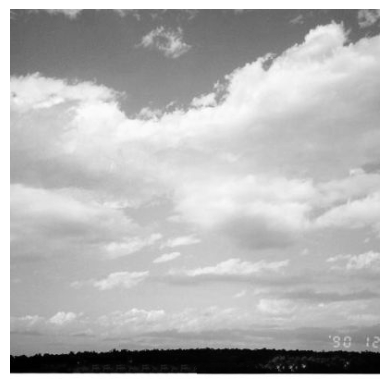

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted ['Sc'] with probabilitiy 9.5%
The true label is ['St']


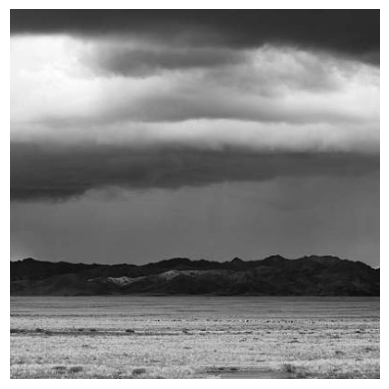

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted ['Sc'] with probabilitiy 9.5%
The true label is ['Ns']


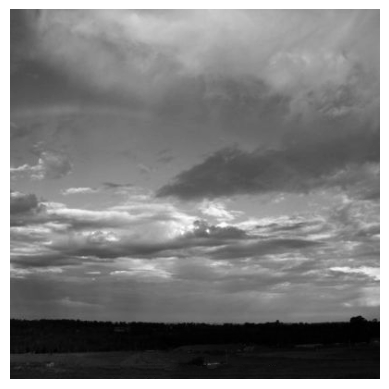

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted ['Sc'] with probabilitiy 9.5%
The true label is ['Ac']


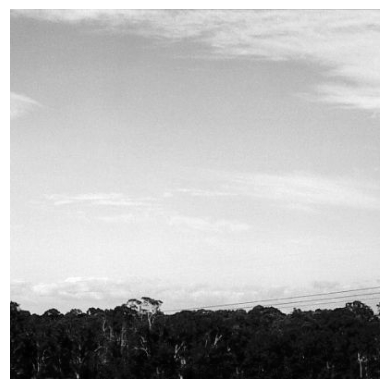

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted ['Sc'] with probabilitiy 9.5%
The true label is ['Cc']


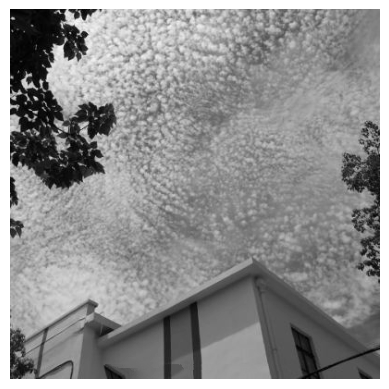

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted ['Sc'] with probabilitiy 9.5%
The true label is ['Cc']


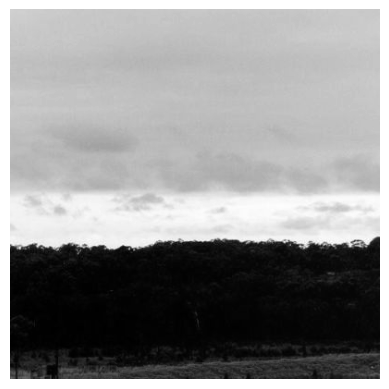

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted ['Sc'] with probabilitiy 9.5%
The true label is ['St']

Got 1 predictions correct out of 10


2024-07-02 19:16:07.657801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
num_samples = 10
num_correct = 0

for sample in data_test.take(10):
    image = sample[0]
    label = sample[1]
    label = np.array(label.numpy()).reshape(1,)
    label_name = le.inverse_transform(label)
    num_correct += prediction_summary(probability_model1, image, label_name)

print()
print(f"Got {num_correct} predictions correct out of {num_samples}")

In [13]:
train_accuracy = model1.evaluate(data_train.batch(batch_size), verbose=2)[1]*100
test_accuracy = model1.evaluate(data_test.batch(batch_size), verbose=2)[1]*100

print(f"The train set got an accuracy of {train_accuracy:.1f}% and the test set got {test_accuracy:.1f}%")

2024-07-02 19:17:48.961435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2081 of 2543
2024-07-02 19:17:51.935515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 - 15s - 458ms/step - accuracy: 0.1346 - loss: 2.3912


2024-07-02 19:18:03.495074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2106 of 2543
2024-07-02 19:18:05.955519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


8/8 - 13s - 2s/step - accuracy: 0.1496 - loss: 2.3920
The train set got an accuracy of 13.5% and the test set got 15.0%


The model is giving the same predictions, 'Sc', with the same probability every time; it doesn't know what to do. The fact the test set did better probably just amounts to more samples with label 'Sc' in the test set. Let's make the model a bit more complex.

### Toddler model

In [14]:
model2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(400,400)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(num_classes)
])

model2.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

model2.fit(data_train.batch(batch_size), epochs=10)

/Users/adu/miniconda3/envs/clouds/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


2024-07-02 19:22:22.491268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2150 of 2543
2024-07-02 19:22:24.855338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - accuracy: 0.1246 - loss: 39.8970
Epoch 2/10


2024-07-02 19:22:42.758094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2211 of 2543
2024-07-02 19:22:44.428644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 221ms/step - accuracy: 0.1230 - loss: 7.3140
Epoch 3/10


2024-07-02 19:23:01.560529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2214 of 2543
2024-07-02 19:23:03.186709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 227ms/step - accuracy: 0.1519 - loss: 3.8015
Epoch 4/10


2024-07-02 19:23:20.486410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2223 of 2543
2024-07-02 19:23:22.110146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 220ms/step - accuracy: 0.1621 - loss: 3.5969
Epoch 5/10


2024-07-02 19:23:39.219012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2114 of 2543
2024-07-02 19:23:41.419269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - accuracy: 0.1750 - loss: 2.8868
Epoch 6/10


2024-07-02 19:23:58.735247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2190 of 2543
2024-07-02 19:24:00.500523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 226ms/step - accuracy: 0.2197 - loss: 2.3565
Epoch 7/10


2024-07-02 19:24:17.766417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2196 of 2543
2024-07-02 19:24:19.521277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - accuracy: 0.1864 - loss: 2.5347
Epoch 8/10


2024-07-02 19:24:37.286199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2210 of 2543
2024-07-02 19:24:39.062486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 231ms/step - accuracy: 0.1723 - loss: 2.6669
Epoch 9/10


2024-07-02 19:24:56.520083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2066 of 2543
2024-07-02 19:24:59.044218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - accuracy: 0.2030 - loss: 2.3977
Epoch 10/10


2024-07-02 19:25:16.481516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2134 of 2543
2024-07-02 19:25:18.712273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - accuracy: 0.2105 - loss: 2.3432


In [15]:
probability_model2 = keras.models.Sequential([
    model2,
    keras.layers.Softmax()
])

2024-07-02 19:25:47.871843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2118 of 2543
2024-07-02 19:25:50.096819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


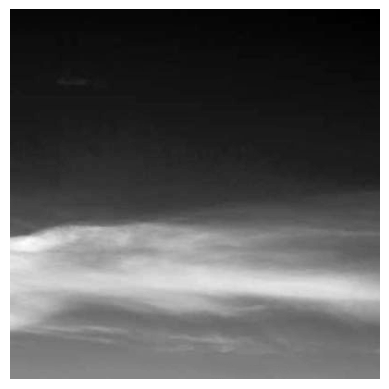

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted ['Ct'] with probabilitiy 51.9%
The true label is ['Cs']


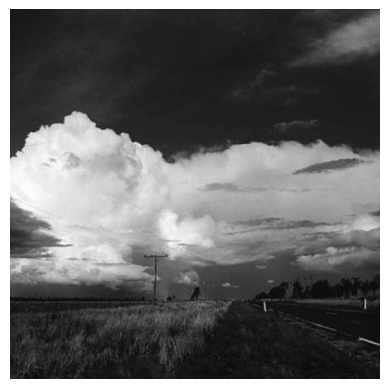

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted ['Cu'] with probabilitiy 36.8%
The true label is ['Cb']


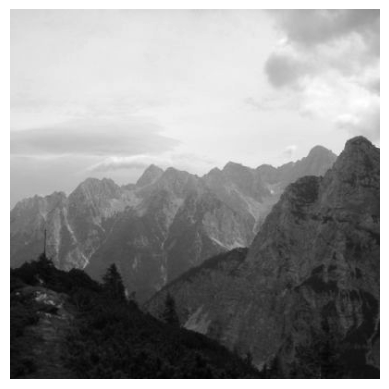

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted ['Sc'] with probabilitiy 49.2%
The true label is ['As']


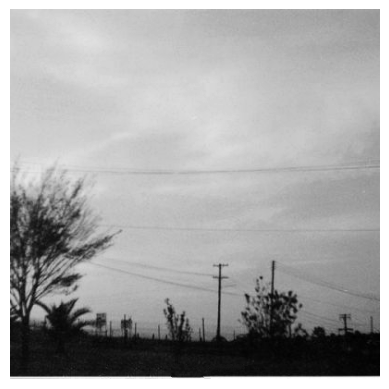

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted ['Sc'] with probabilitiy 84.7%
The true label is ['Cs']


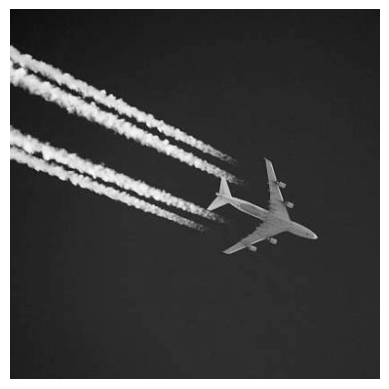

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted ['Ct'] with probabilitiy 16.2%
The true label is ['Ct']


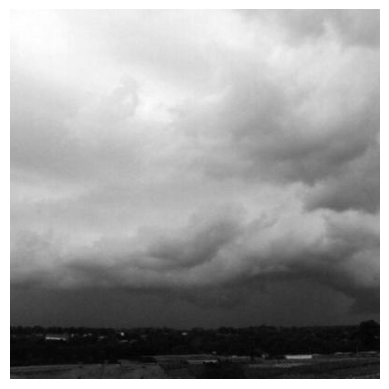

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted ['Sc'] with probabilitiy 50.6%
The true label is ['Sc']


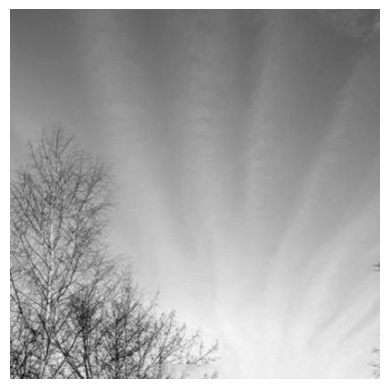

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted ['Ct'] with probabilitiy 61.1%
The true label is ['Ci']


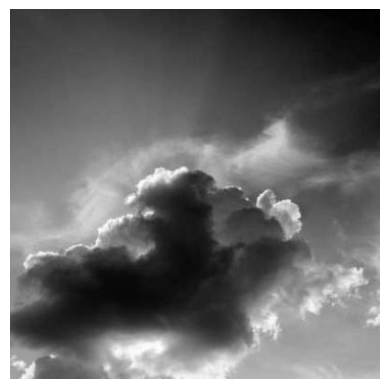

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted ['Ct'] with probabilitiy 24.8%
The true label is ['As']


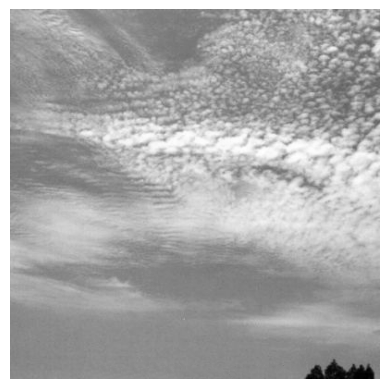

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted ['Cc'] with probabilitiy 22.3%
The true label is ['Cc']


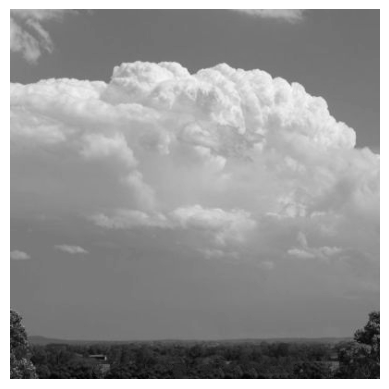

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted ['Sc'] with probabilitiy 31.1%
The true label is ['Cb']

Got 3 predictions correct out of 10


2024-07-02 19:25:51.746935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
num_samples = 10
num_correct = 0

for sample in data_test.take(10):
    image = sample[0]
    label = sample[1]
    label = np.array(label.numpy()).reshape(1,)
    label_name = le.inverse_transform(label)
    num_correct += prediction_summary(probability_model2, image, label_name)

print()
print(f"Got {num_correct} predictions correct out of {num_samples}")

In [17]:
train_accuracy = model2.evaluate(data_train.batch(batch_size), verbose=2)[1]*100
test_accuracy = model2.evaluate(data_test.batch(batch_size), verbose=2)[1]*100

print(f"The train set got an accuracy of {train_accuracy:.1f}% and the test set got {test_accuracy:.1f}%")

2024-07-02 19:26:01.899074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2134 of 2543
2024-07-02 19:26:04.022637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 - 13s - 421ms/step - accuracy: 0.2285 - loss: 2.5057


2024-07-02 19:26:15.258027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2121 of 2543
2024-07-02 19:26:17.488457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


8/8 - 13s - 2s/step - accuracy: 0.2441 - loss: 2.4874
The train set got an accuracy of 22.9% and the test set got 24.4%


Ok it's not just spitting out the same prediction! And the accuracy on the test set is much better than what we would get by a uniform random draw or from always giving the most frequent label, both of these would hover around 9%.

## Save model

In [19]:
probability_model2.save("wu.h5")

## Conclusion

In this notebook we did some basic data preprocessing so we understand how to plug in our data into a keras model. We have a model that can outperform chance. The next step is to refine both procedures: the data processing and the modeling strategy. Next time we'll iterate on this by:

- Creating more data (synthetic data)
- Using a larger model with regularization